### Multivariate time series prediction

This is just the same code as the univariate example, but just to demostrate you are allowed to pass on multivariate data to for prediction. Here I am using a simulated data set:

y = sin(X1) * cos(X2) + noise

You will be using historical X1, X2, and y to predict future y.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Generate 1,000 data points.

In [3]:
# Setting a seed for reproducibility
np.random.seed(42)

# Generate covariates
X1 = np.linspace(0, 10, 1000)  # Linearly spaced numbers between 0 and 10
X2 = np.linspace(0, 5, 1000)  # Linearly spaced numbers between 0 and 5

# Define a non-linear relationship for the target variable
target = np.sin(X1) * np.cos(X2) + np.random.normal(0, 0.1, 1000)  # Adding small noise

# Create a DataFrame
df = pd.DataFrame({
    'X1': X1,
    'X2': X1,
    'Target': target
})

df.head()  # Display the first few rows of the dataframe


,X1,X2,Target
0,0.00000,0.00000,0.049671
1,0.01001,0.01001,-0.003817
2,0.02002,0.02002,0.084787
3,0.03003,0.03003,0.182325
4,0.04004,0.04004,0.016606


In order to use multivariate features, you can re-use the same code, but in the features dataframe, add more predictors, but still make your target/label/dependent variable as the first column.

In [4]:
from sklearn.preprocessing import MinMaxScaler

features = df[['Target','X1','X2']]

target = df[['Target']]


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)
target_normalized = scaler.fit_transform(target)

def create_sequences(data, n_past_steps):
    X, y = [], []
    for i in range(n_past_steps, len(data)):
        X.append(data[i-n_past_steps:i, :])
        y.append(data[i, 0])  # Assuming the first column is PM2.5 and you want to predict it
    return np.array(X), np.array(y)

n_past_steps = 5  # Number of past timesteps you want to use for prediction
X, y = create_sequences(scaled_data, n_past_steps)

The shape your feature matrix should have the dimension as:

995 daily observations, by 5 past days to look back, and by 3 predictors (past X1, past X2, and past y).

In [5]:
X.shape

(995, 5, 3)

In [6]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# Splitting dataset into training and testing sets
split = int(0.8 * len(X))  # 80% for training, 20% for testing

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [7]:
X_train_tensor = torch.Tensor(X_train)  # Convert features to a torch Tensor
y_train_tensor = torch.Tensor(y_train)  # Convert labels to a torch Tensor
X_test_tensor = torch.Tensor(X_test)  # Convert features to a torch Tensor
y_test_tensor = torch.Tensor(y_test)  # Convert labels to a torch Tensor

# Create a TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [8]:
class MultivariateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(MultivariateLSTM, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        self.linear = nn.Linear(hidden_size, 1)

        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        out, _ = self.lstm(x, (h0, c0))
        
        # Index hidden state of last time step
        out = self.linear(out[:, -1, :]) 
        return out


In [9]:
model = MultivariateLSTM(input_size=X.shape[-1], hidden_size=128, num_layers=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
%%time

train_losses = []
val_losses = []

#Number of epochs
epochs = 40
for epoch in range(epochs):
    #turn on training mode
    model.train()
    train_loss = 0
    #For each batch in our training dataset
    for X_batch, y_batch in train_loader:
        #reset gradients
        optimizer.zero_grad()
        #forward to get prediction
        y_pred = model(X_batch)
        #calculate loss
        loss = criterion(y_pred, y_batch)
        #backward to update weights/biases
        loss.backward()
        optimizer.step()
        #sum over loss for all the batches.
        train_loss += loss.item()
    
    #store the average loss
    train_losses.append(train_loss / len(train_loader))

    
    #turn on evaluation mode
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            #forward to get predicton
            y_pred = model(X_batch)
            #calculate loss on test data
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
    #store the average loss
    val_losses.append(val_loss / len(test_loader))

    #print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")

/Users/ziqili/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the 

CPU times: user 2.85 s, sys: 13.4 s, total: 16.3 s
Wall time: 1.53 s


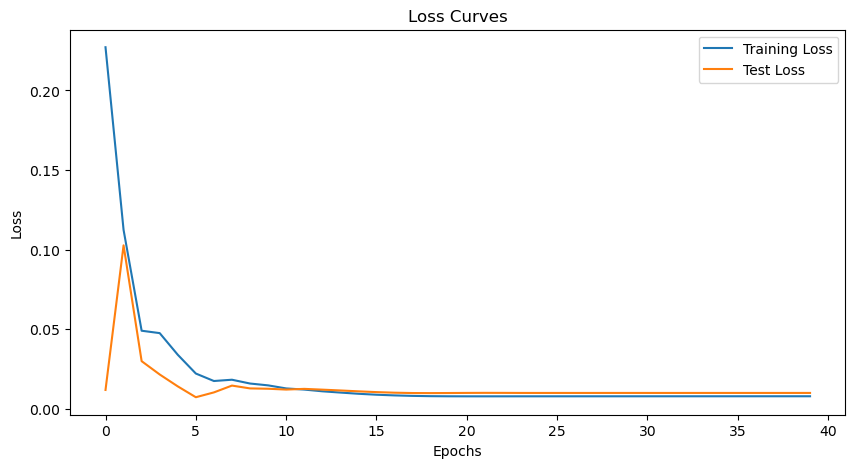

In [11]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Test Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.xlim(0,200)
#plt.ylim(0,0.04)
plt.legend()
plt.show()

In [12]:
model.eval()  # Set the model to evaluation mode
predictions = []
actuals = []

with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        # Store predictions and actual values
        predictions.extend(outputs.view(-1).tolist())
        
        actuals.extend(labels.view(-1).tolist())
        
    for inputs, labels in test_loader:
        outputs = model(inputs)
        # Store predictions and actual values
        predictions.extend(outputs.view(-1).tolist())
        
        actuals.extend(labels.view(-1).tolist())

# Optionally, if you normalized your target variable, you should inverse transform the predictions and actuals here
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).reshape(-1)
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).reshape(-1)

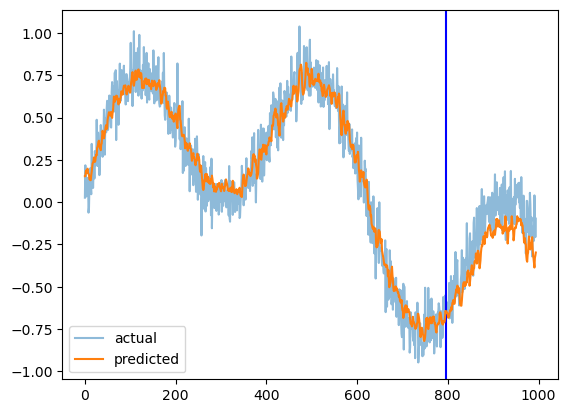

In [13]:
plt.plot(actuals,label="actual",alpha=0.5)
plt.axvline(x = split, color = 'b')
plt.plot(predictions,label="predicted")
plt.legend()